# Project Milestone 2 : _Donald Trump’s Influence on the Covid Infodemic: An Assessment of a Leader’s Impact on (Mis)information Spread_

---
## Context


Donald Trump’s many tweets during the Covid pandemic spread like wildfire, probably making him one of the most influential figures during the pandemic – or did they? Will causal analyses of the effect of Trump’s tweets on Wikipedia and Google Trends pageviews show that he was leading or following online trends? Our goal is to study the impact an influential leader can have on information spread in a crisis with a focus on fake news, as an overload of misleading or contradictory statements (an infodemic, as [WHO](https://www.who.int/health-topics/infodemic#tab=tab_1) calls it) are known to have a detrimental impact on crisis management. To provide a more comprehensive insight into Trump’s actual influence on online information spread, we would also like to compare it with that of other factors such as mobility restrictions or key milestones (e.g. first Covid death).

## Imports :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud

# Local Modules
from wiki_pageviews_covid.analyses.helpers.load import load_interventions, load_aggregated, load_topics, load_pca
from wiki_pageviews_covid.analyses.helpers.vars import codes, helper_langs, interventions_helper, int_c, int_ls
from wiki_pageviews_covid.analyses.helpers.plot import set_size, plot_dates, plot_intervention, plot_cumm_diff
from wiki_pageviews_covid.analyses.helpers.pca import get_attention_shift_ts 
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D

---
## Part 1: Causal Impact Analysis of Trump's Tweets on Wikipedia Pageviews

### A) We start by preparing and familiarizing with our data
- Import & describe (source, size, columns, etc -> similar to homework/tutorials) datasets used for this part
    - Datasets: DT tweets + Wikipedia pageviews
- Preprocess: format, missing values, filtering, transforming, enriching (cf. homework 1) 


Our datasets :
- Covid dataset from ada class
- Donald Trump's tweet between 2019 and
  2021: [Kaggle](https://www.kaggle.com/datasets/codebreaker619/donald-trump-tweets-dataset)
- List of known fake news and their Google trends'
  reference : [GitHub](https://github.com/epfl-dlab/fact-checkers-fact-check/blob/main/data/kg_ids.json)
- Data extracted from Google Trends and Wikipedia (will be done after)

Let's present the Donald Trump's tweets dataset 

In [2]:
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)

/var/folders/g4/t17nc9bs2zqcfjn9vq_f93b80000gn/T/ipykernel_12361/24167535.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)


This dataset contains all his tweets and retweets from 2009 to January, 8 2021 (one day before he was banned from Twitter) :

In [3]:
df.describe()

,id,favorites,retweets,date
count,5.657100e+04,5.657100e+04,56571.000000,56571
mean,7.987865e+17,2.834955e+04,8618.987467,2016-11-14 23:28:23.112902656
min,1.698309e+09,0.000000e+00,0.000000,2009-05-04 00:00:00
25%,4.606192e+17,1.000000e+01,59.000000,2014-04-27 12:00:00
50%,7.471024e+17,1.640000e+02,3450.000000,2016-06-26 00:00:00
75%,1.193134e+18,4.393850e+04,13014.500000,2019-11-09 00:00:00
max,1.347570e+18,1.869706e+06,408866.000000,2021-01-08 00:00:00
std,3.826616e+17,5.781564e+04,13306.132408,NaN


In [4]:
df.sample(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
47758,1021388295618682881,....In my opinion the Washington Post is nothi...,f,f,Twitter for iPhone,69316,14358,2018-07-23,f
40034,780583741051768832,RT @TeamTrump: WATCH: @realDonaldTrump on the ...,t,f,Twitter Web Client,0,1606,2016-09-27,f
1331,1321595603734814720,A vote for Joe Biden is a vote for the biggest...,f,f,Twitter for iPhone,57225,14463,2020-10-28,f
28808,487016134441316353,"""""""@twins44: @realDonaldTrump I could listen t...",f,f,Twitter for Android,18,16,2014-07-09,f
40395,765284051938926592,#AmericasMerkel https://t.co/QFRs4bEUC1,f,f,Twitter for iPhone,17273,8605,2016-08-15,f


There is no empty cell in the dataset :

In [5]:
df.isna().sum()

id           0
text         0
isRetweet    0
isDeleted    0
device       0
favorites    0
retweets     0
date         0
isFlagged    0
dtype: int64

Let's focus on covid period:

In [6]:
df_covid = df[df['date'] >= '2019-12-01']
df_covid.sort_values(by='date')

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
5729,1201207249953263617,"On World AIDS Day, The First Lady and I expres...",f,f,Twitter for iPhone,88404,17422,2019-12-01,f
4461,1200948772253118465,"“Sen. Tim Scott Says Trump 'Innocent,' 'No Way...",f,f,Twitter for iPhone,52381,14045,2019-12-01,f
5731,1200949221224001536,"“Trump did nothing impeachable, day-by-day rev...",f,f,Twitter for iPhone,46554,12497,2019-12-01,f
5728,1201207251035467776,"....in America, community by community where w...",f,f,Twitter for iPhone,51297,10488,2019-12-01,f
5730,1200949712087638017,“Schiff’s impeachment hearings wasting time wh...,f,f,Twitter for iPhone,78199,19648,2019-12-01,f
...,...,...,...,...,...,...,...,...,...
252,1346822610957561858,The States want to redo their votes. They foun...,f,f,Twitter for iPhone,303347,69832,2021-01-06,f
212,1346693906990305280,Get smart Republicans. FIGHT! https://t.co/3fs...,f,f,Twitter for iPhone,127234,26083,2021-01-06,f
316,1347334804052844550,https://t.co/csX07ZVWGe,f,f,Twitter Media Studio,629326,154877,2021-01-08,f
327,1347569870578266115,"To all of those who have asked, I will not be ...",f,f,Twitter for iPhone,510761,83532,2021-01-08,f


In [7]:
time_span = pd.date_range(start = min(df_covid['date']), end = max(df_covid['date']), freq='D')

In [8]:
data=df_covid.copy()
data = pd.merge(data, pd.DataFrame(time_span, columns=['date']), on='date', how='right')

print(data[data.isna()])
#only one nan let'd drop it
data.dropna(inplace=True)
data['per_day_tweets']= data.groupby('date')['date'].transform('count')
data['per_day_retweets']= data.groupby('date')['retweets'].transform('sum')
data['per_day_likes']= data.groupby('date')['favorites'].transform('sum')

       id text isRetweet isDeleted device  favorites  retweets date isFlagged
0     NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
1     NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
2     NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
3     NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
4     NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
...    ..  ...       ...       ...    ...        ...       ...  ...       ...
13514 NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
13515 NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
13516 NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
13517 NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
13518 NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN

[13519 rows x 9 columns]


We can have a look at the temporal evolutions of Trump's tweets :

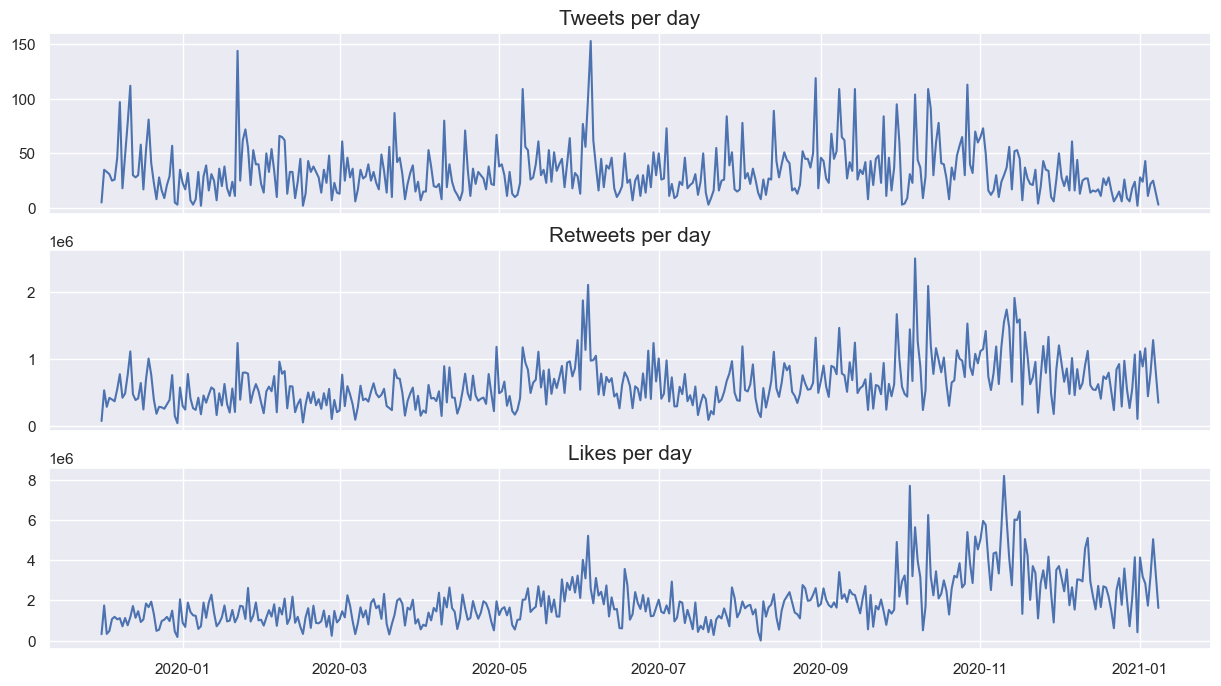

In [9]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex=True, sharey=False)

axes[0].plot(data['date'], data['per_day_tweets'])
axes[0].set_title('Tweets per day', size=15)
axes[1].plot(data['date'], data['per_day_retweets'])
axes[1].set_title('Retweets per day', size=15)
axes[2].plot(data['date'], data['per_day_likes'])
axes[2].set_title('Likes per day', size=15)

plt.show()

There's a correlation between the variables

In [10]:
corr_number_retweets = np.corrcoef(data['per_day_tweets'], data['per_day_retweets'])
print(f'Correlation Coefficient: {corr_number_retweets[0, 1]:.2f}')
corr_number_likes = np.corrcoef(data['per_day_tweets'], data['per_day_likes'])
print(f'Correlation Coefficient: {corr_number_likes[0, 1]:.2f}')
corr_number_likes_retweets = np.corrcoef(data['per_day_retweets'], data['per_day_likes'])
print(f'Correlation Coefficient: {corr_number_likes_retweets[0, 1]:.2f}')


Correlation Coefficient: 0.66
Correlation Coefficient: 0.26
Correlation Coefficient: 0.78


Finally, let's have an idea of the type of tweets we have :

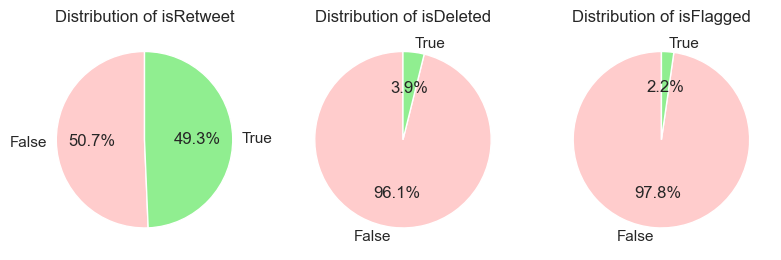

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(8, 12))

variables = ['isRetweet', 'isDeleted', 'isFlagged']
colors = ['#FFCCCC', 'lightgreen']

for i, var in enumerate(variables):
    ax = axes[i]
    ax.pie(data[var].value_counts(), labels=['False', 'True'], autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f'Distribution of {var}')

plt.tight_layout()
plt.show()


There are very few deleted tweets, though they can be an indication of misinformation from trump.

### B) We can now perform our first causal analyses
_Note:_ For every piece of analysis, we should briefly explain the theory/math (document this!), include visualizations & statistical tests and (optionally?) model training

__Proposed analysis pipeline__ for this part 1.B:
- Matteo's analysis leading to the very interesting Wikipedia pageviews - DT tweet plot
- Causal analysis with Google library (as we need the events - DT tweets - to know where to expect a causal effect): https://google.github.io/CausalImpact/CausalImpact.html
- Granger causality test: "Is Trump leading or following the trend?"
- Some model training (You think that's relevant? Ask Manoel?)

Let's focus on covid topics

Before running following command install dictionary with:

python -m spacy download en_core_web_sm

In [12]:
#download a english dictionary to make anlysis
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))

Number of stop words: 326


In [13]:
#put all the text togheter
result_text = ' '.join(data['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])


#max length for spaCy nlp
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]

# Process each chunk separately
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

In [14]:
clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)
clean= clean.translate(str.maketrans('', '', string.punctuation))
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')


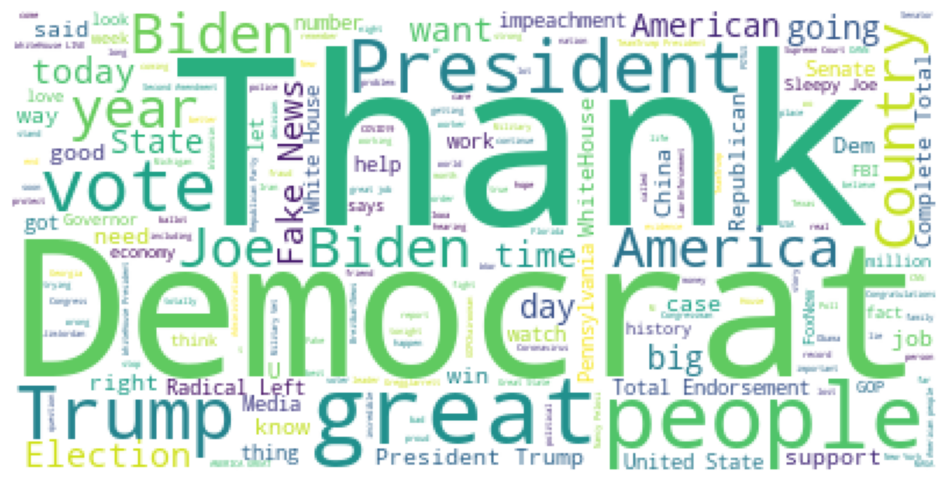

In [15]:
## PUT IT IN SECTION A?
#generating the wordcloud
wordcloud = WordCloud(background_color="white").generate(clean)

#plot the wordcloud
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

#to remove the axis value
plt.axis("off")
plt.show()

In [16]:
list_of_words = ['Covid19', 'virus', 'China', 'vaccine', 'Flu', 'Covid', 'lockdown', 'pandemic', 'coronavirus', 'Coronavirus', 'Corona', 'corona', 'COVID19', 'COVID', 'covid', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantined', 'Quarantined', 'quarentined', 'Quarentined', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines']
data['covid_related'] = data['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)

data['covid_related'].value_counts()

covid_related
False    12662
True       856
Name: count, dtype: int64

Find the moment when the topic is the most popular

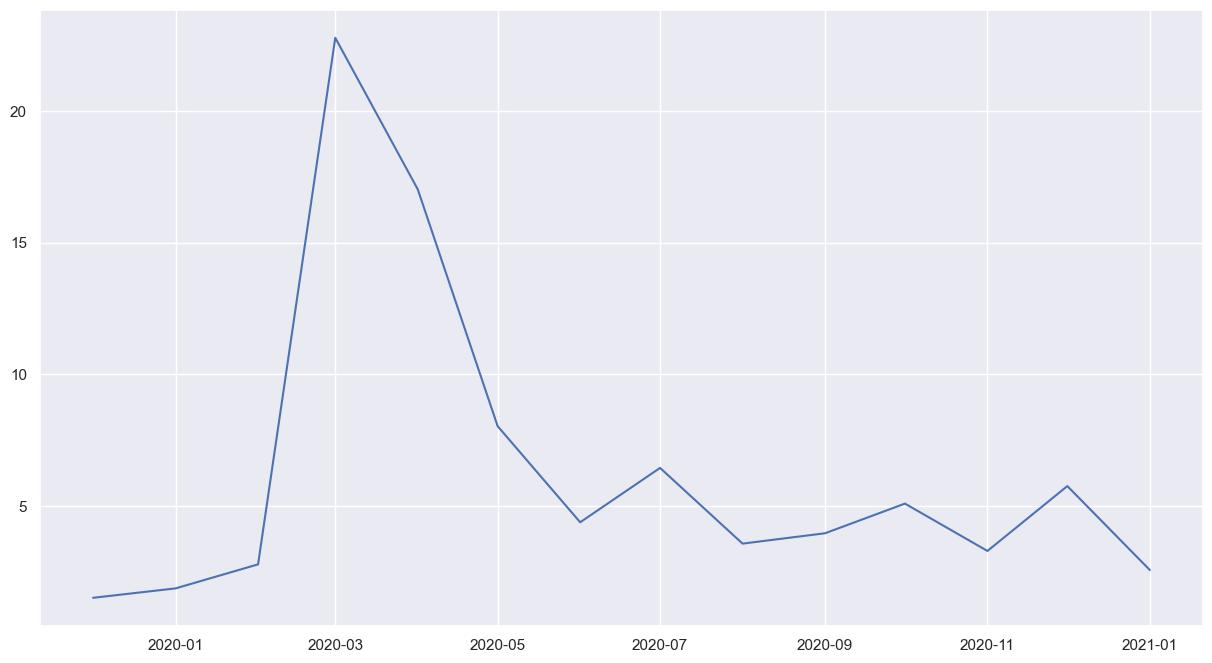

In [17]:
#fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex=True, sharey=False)
data['month_date'] = data.date.apply(lambda x: x.month)
data['year_date'] = data.date.apply(lambda x: x.year)
frequency_plot = data.groupby(by=['month_date', 'year_date']).apply(lambda x: x.covid_related.sum() / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)

# plt.plot(data['date'], data['id'], c=data['covid_related'], cmap='viridis')
# plt.title('Covid related tweets', size=15)
# plt.show()


Now let's discover if among the most retweeted and the most liked tweets there are some that are related to covid

In [18]:
data['decile_retweeted'] = pd.qcut(data['retweets'], 10, labels=False, duplicates='drop')
data['decile_favorited'] = pd.qcut(data['favorites'], 10, labels=False, duplicates='drop')
data.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,per_day_tweets,per_day_retweets,per_day_likes,covid_related,month_date,year_date,decile_retweeted,decile_favorited
0,1.200949e+18,"“Sen. Tim Scott Says Trump 'Innocent,' 'No Way...",f,f,Twitter for iPhone,52381.0,14045.0,2019-12-01,f,5,74100.0,316835.0,False,12,2019,5,2
1,1.201207e+18,"....in America, community by community where w...",f,f,Twitter for iPhone,51297.0,10488.0,2019-12-01,f,5,74100.0,316835.0,False,12,2019,3,2
2,1.201207e+18,"On World AIDS Day, The First Lady and I expres...",f,f,Twitter for iPhone,88404.0,17422.0,2019-12-01,f,5,74100.0,316835.0,False,12,2019,6,3
3,1.200950e+18,“Schiff’s impeachment hearings wasting time wh...,f,f,Twitter for iPhone,78199.0,19648.0,2019-12-01,f,5,74100.0,316835.0,False,12,2019,6,3
4,1.200949e+18,"“Trump did nothing impeachable, day-by-day rev...",f,f,Twitter for iPhone,46554.0,12497.0,2019-12-01,f,5,74100.0,316835.0,False,12,2019,4,1


In [19]:
data_covid_favorites = data.query('covid_related == True and (decile_favorited == 9 or decile_favorited == 8 or decile_favorited == 7 or decile_retweeted == 9 or decile_retweeted == 8 or decile_retweeted == 7)')

In [20]:
data_covid_favorites.shape

(250, 17)

There are some popular tweets that are related to covid let's see if they also contain words related to possible fake news

In [21]:
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = data_covid_favorites['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

In [22]:
analyze.value_counts()

text
False    249
True       1
Name: count, dtype: int64

### If we don't filter per covid and quantile

In [23]:
analyze1 = data['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)
analyze1.value_counts()

text
False    13496
True        22
Name: count, dtype: int64

### If we don't filter per quantile

In [24]:
dg = data[data['covid_related'] == True]
analyze2 = dg['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)
analyze2.value_counts()

text
False    849
True       7
Name: count, dtype: int64

### If we don't filter per covid

In [25]:
dq = data.query('decile_favorited == 9 or decile_favorited == 8 or decile_favorited == 7 or decile_retweeted == 9 or decile_retweeted == 8 or decile_retweeted == 7')
analyze3 = dg['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)
analyze3.value_counts()

text
False    849
True       7
Name: count, dtype: int64

In [26]:
# create a new column with the result of the analysis
new_col = analyze3.reindex(data.index, fill_value=False)
data['Hydroxychloroquine']=new_col

We should focus on the last one

Text(0.5, 1.0, 'Covid related tweets')

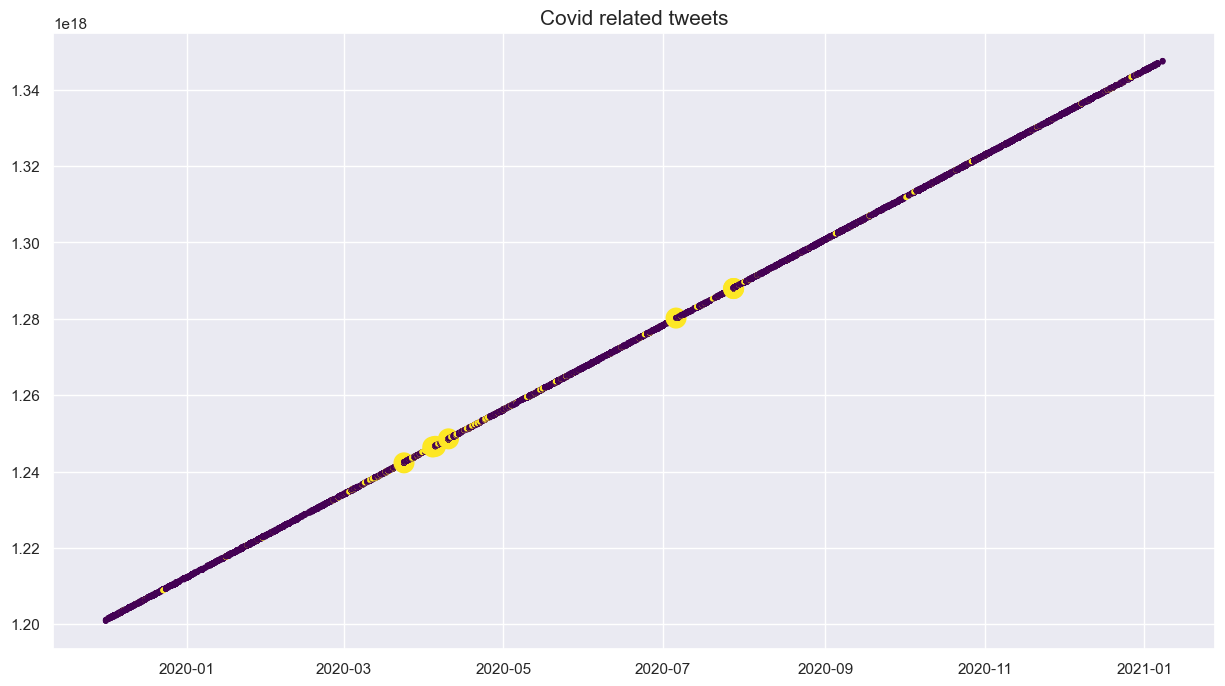

In [27]:
condition = data['Hydroxychloroquine']  # Replace 'condition_column' with your actual column name

# Define the sizes of the dots (10 for False, 50 for True)
sizes = [10 if not cond else 200 for cond in condition]

# Scatter plot with custom sizes
plt.scatter(data['date'], data['id'], c=data['covid_related'], cmap='viridis', s=sizes)

# Add title
plt.title('Covid related tweets', size=15)

In [28]:
trend_data = []

month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# Load JSON data
with open('hydroxychloroquine_googletrends.json', 'r') as file:
    data_views = json.load(file)

    for date in data_views['interest_over_time']['timeline_data']:
        parts = date['date'].replace('–', ' '). replace(',', ' ').split()
        if len(parts) == 6:
            trend_data.append({'date': datetime(year=int(parts[2]), month=month_mapping[parts[0]], day=int(parts[1])), 'value': int(date['values'][0]['value'])})
        else:
            trend_data.append({'date': datetime(year=int(parts[-1]), month=month_mapping[parts[0]], day=int(parts[1])), 'value': int(date['values'][0]['value'])})

# Create DataFrame from the list
trend_df = pd.DataFrame(trend_data)

In [29]:
trend_df

,date,value
0,2020-01-05,1
1,2020-01-12,1
2,2020-01-19,1
3,2020-01-26,1
4,2020-02-02,1
5,2020-02-09,1
6,2020-02-16,1
7,2020-02-23,1
8,2020-03-01,1
9,2020-03-08,2


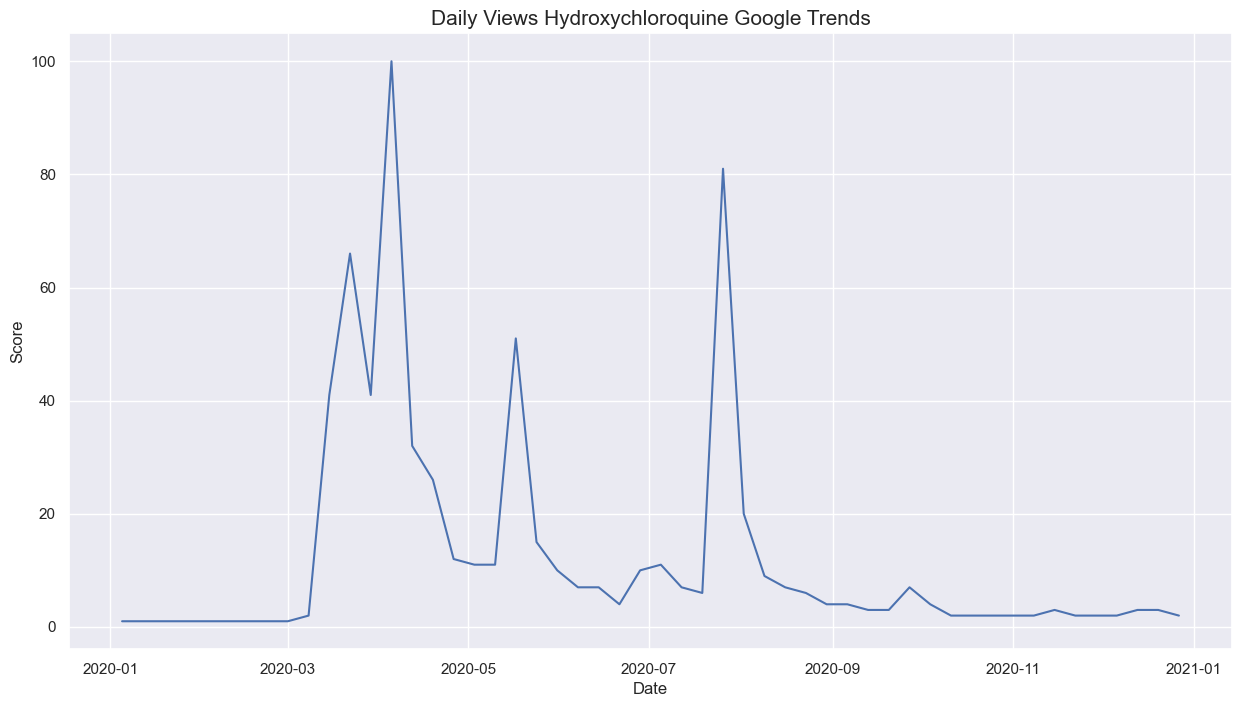

In [30]:

plt.plot(trend_df.date, trend_df.value)
plt.title('Daily Views Hydroxychloroquine Google Trends', size=15)
plt.xlabel('Date')
plt.ylabel('Score')
plt.show()

In [31]:
import pandas as pd
import json

# Load JSON data
with open('hydroxychloroquine_wikipedia.json', 'r') as file:
    data_views = json.load(file)

# Extract dates and views
datess = [item['timestamp'] for item in data_views['items']]
views = [item['views'] for item in data_views['items']]

# Combine dates and views into a list of tuples
date_views_list = list(zip(datess, views))

# Create a Pandas DataFrame
df = pd.DataFrame(date_views_list, columns=['Date', 'Views'])

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d00')

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Convert the 'Views' column to a Pandas Series
views_series = df['Views']


In [32]:
# get the dates where trump spoke
critical_data = data[data['Hydroxychloroquine'] == True]['date']
specific_dates = pd.to_datetime(critical_data, format='%Y%m%d')

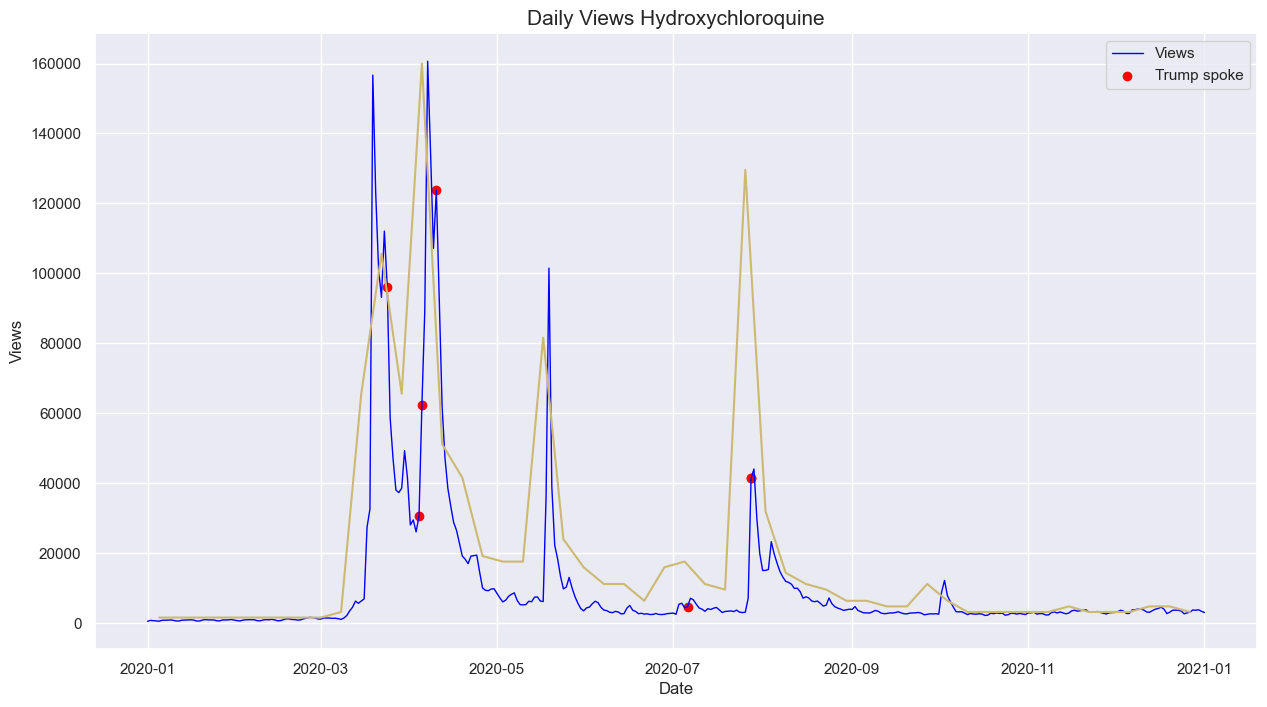

In [33]:
specific_views = views_series.loc[specific_dates]

# Plotting the data
plt.plot(views_series, color='blue', linewidth=1)
plt.scatter(specific_views.index, specific_views, color='red')  # Add red dots
plt.plot(trend_df.date, trend_df.value * 1600, color = 'y')
plt.title('Daily Views Hydroxychloroquine', size=15)
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend(['Views', 'Trump spoke'])
plt.show()

In [34]:
import os

### Code to download wikipedia timeseries of page
## Start of parameters to set
saving_path = 'hydroxychloroquine_wikipedia.json'
page_name = 'Hydroxychloroquine'
start_date = datetime(year=2020, month=1, day=1)
end_date = datetime(year=2021, month=1, day=1)
## End of parameters to set

command = 'wget -O {saving_path} \'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/{page_name}/daily/{start_date}/{end_date}\''\
            .format(saving_path=saving_path, page_name=page_name, start_date=start_date.strftime('%Y%m%d%H'), end_date=end_date.strftime('%Y%m%d%H'))

os.system(command)

--2023-11-16 16:49:40--  https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/Hydroxychloroquine/daily/2020010100/2021010100
Résolution de wikimedia.org (wikimedia.org)… 185.15.58.224
Connexion à wikimedia.org (wikimedia.org)|185.15.58.224|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 56927 (56K) [application/json]
Sauvegarde en : « hydroxychloroquine_wikipedia.json »

     0K .......... .......... .......... .......... .......... 89% 1,73M 0s
    50K .....                                                 100% 13,8M=0,03s

2023-11-16 16:49:40 (1,89 MB/s) — « hydroxychloroquine_wikipedia.json » sauvegardé [56927/56927]



0

In [35]:
# to install: pip install google-search-results

from serpapi import GoogleSearch
import json

### Code to download wikipedia timeseries of page
## Start of parameters to set
saving_path = 'hydroxychloroquine_googletrends.json'
page_name = 'Hydroxychloroquine'
start_date = datetime(year=2020, month=1, day=1)
end_date = datetime(year=2021, month=1, day=1)
## End of parameters to set

params = {
  "engine": "google_trends",
  "q": page_name,
  "data_type": "TIMESERIES",
  "api_key": "dd2b1a64c96847db4dc6d2d2146d7eed59a48a6657355d7a5232f91b1f463f25",
  "date": "{start_date} {end_date}".format(start_date=start_date.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d'))
}

search = GoogleSearch(params)
results = search.get_dict()

json_object = json.dumps(results)
with open(saving_path, 'w') as f:
  f.write(json_object)

___
## Part 2: Causal Impact Analyis of Alternative Hypotheses
__Proposition:__ Conduct analyses similar to the above (though briefer) with:
1) Dataset description + preprocessing
2) Visualiation + Granger causality test + (optionally) model training
on the following data:
- tweets/announcements by other ppl
- interventions (restrictions & co, cf Wikidata)
- mobility reports (Apple/Google)

The following part is freely inspired from the work [Sudden Attention Shifts on Wikipedia During the COVID-19 Crisis](https://github.com/epfl-dlab/wiki_pageviews_covid)

In [36]:
params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
#     'font.family': 'Linux Libertine Display',
    'text.usetex': True
}

mpl.rcParams.update(params)

In [ ]:
interventions = load_interventions("wiki_pageviews_covid/data/interventions.csv")
topics_df, topics = load_topics('wiki_pageviews_covid/data/topics_linked.csv.xz')
agg = load_aggregated("wiki_pageviews_covid/data/aggregated_timeseries.json.gz")
codes_order = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]
dfs_pca_shift = load_pca(codes_order, pca_folder="wiki_pageviews_covid/data/pca/")

In [ ]:
print(specific_views.index)

In [ ]:
# COVID-RELATED PAGEVIEWS
idx =3
fig, axs = plt.subplots(2, 1,
                       figsize=(14, 10),
                       sharex=False,
                       gridspec_kw={"hspace": 0.9, "wspace": 0.15, "top": 0.7})

ax = axs[0]
code = codes_order[idx]
ax.set_ylabel(helper_langs[code], rotation=0, ha="right", va="center", fontsize=14)
start, end = plot_dates(ax, 20200114, 20200731, 
                        agg[code]["sum"].index,
                        (agg[code]["covid"]["sum"].values + agg[code + ".m"]["covid"]["sum"].values +1) 
                        / (agg[code]["sum"].values + agg[code+".m"]["sum"].values),  sci=False, color="#377eb8")

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('right')
ax.set_yscale("log")
ax.set_ylim([10**(-6), 5* 10**(-2)])
ax.set_yticks([10**(-4), 10**(-2)])

# NON COVID-RELATED PAGEVIEWS

ax = axs[1]

ax_twin = ax.twiny()

start, end = plot_dates(ax, 20200114, 20200731, 
                    agg[code]["sum"].index, agg[code]["sum"].values + agg[code + ".m"]["sum"].values -
                    agg[code]["covid"]["sum"].values - agg[code +".m"]["covid"]["sum"].values, 
                        color="#377eb8", sci=False)

plot_dates(ax_twin, 20190114, 20190731, agg[code]["sum"].index,
           agg[code]["sum"].values + agg[code + ".m"]["sum"].values -
           agg[code]["covid"]["sum"].values - agg[code +".m"]["covid"]["sum"].values,
           adjust=(start, end), sci=False, xticklabels=False, ls=":", color="#377eb8")

axs[0].plot(views_series/4e6, color='blue', linewidth=1)
axs[0].scatter(specific_views.index, [0.01]*len(specific_views.index), color='red')  # Add red dots
axs[1].plot(views_series*4e3, color='blue', linewidth=1)

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

for ax_t in [ax, ax_twin]:
    ax_t.spines['left'].set_visible(False)
    ax_t.spines['top'].set_visible(False)
    ax_t.yaxis.set_ticks_position('right')
    
axs[1].scatter(specific_views.index, [2.5e8]*len(specific_views.index), color='red')  # Add red dots

axs[0].set_title("\% COVID-19-related pageviews \n ($log_{10}$ scale)", pad=35)
axs[1].set_title("Number of pageviews not\n related to COVID-19 ", pad=35)
#axs[2].set_title("Cumulative pageviews difference \n w/ last year (normalized)", pad=35)
#axs[3].set_title("Distance from Normality", pad=35)

lines = [
    Line2D([0], [0], color="#377eb8", lw=1.5, ls="-"),
    Line2D([0], [0], color="#377eb8", lw=1.5, ls=":"),
    Line2D([0], [0], color="black", lw=1.5, ls=":")
]

axs[0].legend(
    handles=lines,
    labels=["2020", "2019"],
    loc='upper center', bbox_to_anchor=(0.3, 2),
    ncol=3, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=13
)


lines_interv = [Line2D([0], [0], color=int_c[x], ls=int_ls[x], alpha=0.3 if x != "Mobility" else 1.) 
                for x, _ in interventions_helper.items()]

axs[1].legend(
    handles= lines_interv,
    labels=["{}: {}".format(v, 
                            k.replace("Mobility", "Mobility changepoint")\
                            .replace("Normalcy", "Normality changepoint"))
            for k, v in interventions_helper.items()],
    loc='upper center', bbox_to_anchor=(.5,3.7),
    ncol=4, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=12
)